In [ ]:
import os
import gc
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    pipeline
)
from tqdm import tqdm
import evaluate
import json
from datetime import datetime

# ---------------- CONFIG ----------------
MODEL_DICT = {
    "t5":         "t5-base",
}

OUTPUT_ROOT = "./finetuned_cnn_dm_sentiment"
RESULTS_ROOT = "./results_csv"
os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(RESULTS_ROOT, exist_ok=True)

MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 128
NUM_EPOCHS = 2
BATCH_SIZE = 2
LEARNING_RATE = 5e-5
TRAIN_SIZE = 3000  # Made configurable

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Training on: {device}")

# ---------------- LOAD DATASET ----------------
def load_and_prepare_dataset():
    """Load and prepare the CNN/DailyMail dataset"""
    print("Loading dataset...")
    dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")
    dataset = dataset["train"].select(range(TRAIN_SIZE))
    return dataset

# ---------------- METRIC ----------------
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred, tokenizer):
    """Compute ROUGE metrics for evaluation"""
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean up predictions and labels
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in result.items()}

# ---------------- SENTIMENT ANALYSIS SETUP ----------------
def setup_sentiment_pipelines():
    """Initialize all sentiment analysis pipelines"""
    print("Setting up sentiment analysis pipelines...")
    
    pipelines = {}
    try:
        pipelines['polarity'] = pipeline("sentiment-analysis", 
                                        model="cardiffnlp/twitter-roberta-base-sentiment-latest")
    except:
        pipelines['polarity'] = pipeline("sentiment-analysis")
    
    try:
        pipelines['finegrained'] = pipeline("sentiment-analysis", 
                                           model="nlptown/bert-base-multilingual-uncased-sentiment")
    except:
        print("Warning: Fine-grained sentiment model not available, skipping...")
        pipelines['finegrained'] = None
    
    try:
        pipelines['emotion'] = pipeline("text-classification", 
                                       model="j-hartmann/emotion-english-distilroberta-base", 
                                       return_all_scores=True)
    except:
        print("Warning: Emotion model not available, skipping...")
        pipelines['emotion'] = None
    
    try:
        pipelines['zero_shot'] = pipeline("zero-shot-classification", 
                                         model="facebook/bart-large-mnli")
    except:
        print("Warning: Zero-shot model not available, skipping...")
        pipelines['zero_shot'] = None
    
    return pipelines

# Labels for zero-shot classification
INTENT_LABELS = ["informative", "warning", "opinion", "breaking news", "analysis"]
ASPECT_LABELS = ["economy", "politics", "health", "sports", "technology", "entertainment"]

# ---------------- TRAINING FUNCTION ----------------
def train_and_save(model_key, model_name, dataset, sentiment_pipelines):
    """Train a model and return inference function"""
    print(f"\n🚀 Fine-tuning {model_key}...")
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        # Add pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
        
        def preprocess(batch):
            inputs = batch["article"]
            if "t5" in model_key:
                inputs = ["summarize: " + text for text in inputs]
            
            model_inputs = tokenizer(
                inputs, 
                max_length=MAX_INPUT_LEN, 
                truncation=True, 
                padding="max_length"
            )
            
            labels = tokenizer(
                batch["highlights"], 
                max_length=MAX_TARGET_LEN, 
                truncation=True, 
                padding="max_length"
            )
            
            model_inputs["labels"] = labels["input_ids"]
            return model_inputs
        
        # Split dataset
        split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
        ds_train = split_dataset["train"]
        ds_val = split_dataset["test"]
        
        print(f"Training samples: {len(ds_train)}")
        print(f"Validation samples: {len(ds_val)}")
        
        # Tokenize datasets
        tokenized_train = ds_train.map(preprocess, batched=True, remove_columns=ds_train.column_names)
        tokenized_val = ds_val.map(preprocess, batched=True, remove_columns=ds_val.column_names)
        
        collator = DataCollatorForSeq2Seq(tokenizer, model)
        
        args = Seq2SeqTrainingArguments(
            output_dir=f"{OUTPUT_ROOT}/{model_key}",
            eval_strategy="epoch",
            learning_rate=LEARNING_RATE,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            num_train_epochs=NUM_EPOCHS,
            weight_decay=0.01,
            save_strategy="epoch",
            save_total_limit=2,
            predict_with_generate=True,
            fp16=torch.cuda.is_available(),
            logging_dir=f"{OUTPUT_ROOT}/{model_key}/logs",
            report_to="none",
            load_best_model_at_end=True,
            metric_for_best_model="eval_rouge1",
            greater_is_better=True,
            max_grad_norm=1.0,
        )
        
        trainer = Seq2SeqTrainer(
            model=model,
            args=args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            tokenizer=tokenizer,
            data_collator=collator,
            compute_metrics=lambda x: compute_metrics(x, tokenizer),
        )
        
        # Train the model
        trainer.train()
        
        # Save model and tokenizer
        trainer.save_model(f"{OUTPUT_ROOT}/{model_key}")
        tokenizer.save_pretrained(f"{OUTPUT_ROOT}/{model_key}")
        
        # Save training metrics
        training_history = trainer.state.log_history
        with open(f"{OUTPUT_ROOT}/{model_key}/training_history.json", "w") as f:
            json.dump(training_history, f, indent=2)
        
        print(f"✅ {model_key} training completed and saved!")
        
        # Create inference function
        def summarize_with_sentiments(article_text):
            try:
                prefix = "summarize: " if "t5" in model_key else ""
                inputs = tokenizer(
                    prefix + article_text, 
                    return_tensors="pt", 
                    truncation=True, 
                    max_length=MAX_INPUT_LEN
                )
                inputs = {k: v.to(model.device) for k, v in inputs.items()}
                
                with torch.no_grad():
                    ids = model.generate(
                        **inputs, 
                        max_length=MAX_TARGET_LEN, 
                        num_beams=4, 
                        early_stopping=True,
                        no_repeat_ngram_size=2
                    )
                
                summary = tokenizer.decode(ids[0], skip_special_tokens=True)
                trainer.save_model(f"{OUTPUT_ROOT}/{model_key}")
                tokenizer.save_pretrained(f"{OUTPUT_ROOT}/{model_key}")
                # Perform sentiment analysis
                result = {"summary": summary, "model": model_key}
                
                # Polarity analysis
                if sentiment_pipelines['polarity']:
                    try:
                        polarity = sentiment_pipelines['polarity'](summary)[0]
                        result["polarity"] = polarity
                    except Exception as e:
                        print(f"Polarity analysis failed: {e}")
                        result["polarity"] = {"label": "UNKNOWN", "score": 0.0}
                
                # Fine-grained sentiment
                if sentiment_pipelines['finegrained']:
                    try:
                        finegrained = sentiment_pipelines['finegrained'](summary)[0]
                        result["finegrained"] = finegrained
                    except Exception as e:
                        print(f"Fine-grained analysis failed: {e}")
                        result["finegrained"] = {"label": "UNKNOWN", "score": 0.0}
                
                # Emotion analysis
                if sentiment_pipelines['emotion']:
                    try:
                        emotions = sentiment_pipelines['emotion'](summary)[0]
                        result["emotions"] = emotions
                    except Exception as e:
                        print(f"Emotion analysis failed: {e}")
                        result["emotions"] = []
                
                # Intent classification
                if sentiment_pipelines['zero_shot']:
                    try:
                        intent = sentiment_pipelines['zero_shot'](summary, candidate_labels=INTENT_LABELS)
                        result["intent"] = intent
                    except Exception as e:
                        print(f"Intent classification failed: {e}")
                        result["intent"] = {"labels": [], "scores": []}
                
                # Aspect classification
                if sentiment_pipelines['zero_shot']:
                    try:
                        aspects = sentiment_pipelines['zero_shot'](summary, candidate_labels=ASPECT_LABELS)
                        result["aspects"] = aspects
                    except Exception as e:
                        print(f"Aspect classification failed: {e}")
                        result["aspects"] = {"labels": [], "scores": []}
                
                return result
                
            except Exception as e:
                print(f"Error in summarization: {e}")
                return {
                    "summary": "Error generating summary",
                    "model": model_key,
                    "error": str(e)
                }
        
        return summarize_with_sentiments
    
    except Exception as e:
        print(f"❌ Error training {model_key}: {e}")
        return None

# ---------------- MAIN EXECUTION ----------------
def main():
    """Main execution function"""
    print("🚀 Starting CNN/DailyMail Fine-tuning Pipeline")
    print(f"Timestamp: {datetime.now()}")
    
    # Load dataset
    dataset = load_and_prepare_dataset()
    
    # Setup sentiment pipelines
    sentiment_pipelines = setup_sentiment_pipelines()
    
    # Train models and collect inference functions
    model_functions = {}
    for key, name in MODEL_DICT.items():
        print(f"\n{'='*50}")
        summarize_fn = train_and_save(key, name, dataset, sentiment_pipelines)
        if summarize_fn:
            model_functions[key] = summarize_fn
            # Clear memory after each model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
    
    # Test on sample articles
    sample_articles = [dataset[i]["article"] for i in range(10)]  # Reduced for faster testing
    
    for key, fn in model_functions.items():
        results = []
        print(f"\n📊 Processing test articles with {key}...")
        
        for i, article in enumerate(tqdm(sample_articles, desc=f"{key} inference")):
            try:
                res = fn(article)
                res["article_id"] = i
                res["article_snippet"] = article[:200] + "..." if len(article) > 200 else article
                results.append(res)
            except Exception as e:
                print(f"Error processing article {i} with {key}: {e}")
                continue

        # Save results
        if results:
            df = pd.DataFrame(results)
            output_file = f"{RESULTS_ROOT}/{key}_results.csv"
            df.to_csv(output_file, index=False)
            print(f"✅ Saved {len(results)} results to {output_file}")
    
    print(f"\n🎉 Pipeline completed! Check results in {RESULTS_ROOT}/")

if __name__ == "__main__":
    main()


In [ ]:
import os
import gc
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    pipeline
)
from tqdm import tqdm
import evaluate
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ---------------- CONFIG ----------------
# Update these paths based on your setup
FINETUNED_MODEL_PATH = "./finetuned_cnn_dm_sentiment/t5"  
NORMAL_MODEL_NAME = "t5-base"
OUTPUT_DIR = "./model_comparison_results"
PLOTS_DIR = "./comparison_plots"

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Parameters
MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 128
TEST_SIZE = 20000  
BATCH_SIZE = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Running comparison on: {device}")

# ---------------- LOAD MODELS ----------------
def load_models():
    """Load both fine-tuned and normal T5 models"""
    print("Loading models...")
    
    models = {}
    tokenizers = {}
    
    try:
        # Load fine-tuned model
        print("Loading fine-tuned T5 model...")
        tokenizers['finetuned'] = AutoTokenizer.from_pretrained(FINETUNED_MODEL_PATH)
        models['finetuned'] = AutoModelForSeq2SeqLM.from_pretrained(FINETUNED_MODEL_PATH).to(device)
        print("✅ Fine-tuned model loaded successfully!")
        
        # Load normal T5 model
        print("Loading normal T5-base model...")
        tokenizers['normal'] = AutoTokenizer.from_pretrained(NORMAL_MODEL_NAME)
        models['normal'] = AutoModelForSeq2SeqLM.from_pretrained(NORMAL_MODEL_NAME).to(device)
        print("✅ Normal T5 model loaded successfully!")
        
        return models, tokenizers
        
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None, None

# ---------------- LOAD TEST DATA ----------------
def load_test_data():
    """Load CNN/DailyMail test data"""
    print("Loading test dataset...")
    dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")
    test_data = dataset["test"].select(range(TEST_SIZE))
    print(f"✅ Loaded {len(test_data)} test articles")
    return test_data

# ---------------- METRICS ----------------
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def calculate_text_stats(text):
    """Calculate basic text statistics"""
    words = text.split()
    sentences = text.split('.')
    return {
        'word_count': len(words),
        'sentence_count': len([s for s in sentences if s.strip()]),
        'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
        'char_count': len(text)
    }

def compute_metrics(predictions, references, model_name):
    """Compute comprehensive metrics"""
    print(f"Computing metrics for {model_name}...")
    
    # ROUGE metrics
    rouge_scores = rouge.compute(
        predictions=predictions, 
        references=references, 
        use_stemmer=True
    )
    
    # BLEU score
    bleu_score = bleu.compute(
        predictions=predictions,
        references=[[ref] for ref in references]
    )
    
    # Text statistics
    pred_stats = [calculate_text_stats(pred) for pred in predictions]
    ref_stats = [calculate_text_stats(ref) for ref in references]
    
    # Aggregated statistics
    metrics = {
        'rouge1': rouge_scores['rouge1'] * 100,
        'rouge2': rouge_scores['rouge2'] * 100,
        'rougeL': rouge_scores['rougeL'] * 100,
        'bleu': bleu_score['bleu'] * 100,
        'avg_pred_length': np.mean([s['word_count'] for s in pred_stats]),
        'avg_ref_length': np.mean([s['word_count'] for s in ref_stats]),
        'avg_pred_sentences': np.mean([s['sentence_count'] for s in pred_stats]),
        'avg_ref_sentences': np.mean([s['sentence_count'] for s in ref_stats]),
        'length_ratio': np.mean([s['word_count'] for s in pred_stats]) / np.mean([s['word_count'] for s in ref_stats]),
        'predictions': predictions,
        'references': references,
        'pred_stats': pred_stats,
        'ref_stats': ref_stats
    }
    
    return metrics

# ---------------- MODEL INFERENCE ----------------
def generate_summaries(model, tokenizer, articles, model_name):
    """Generate summaries using the model"""
    print(f"Generating summaries with {model_name}...")
    
    summaries = []
    inference_times = []
    
    for article in tqdm(articles, desc=f"{model_name} inference"):
        try:
            start_time = datetime.now()
            
            # Prepare input
            input_text = f"summarize: {article}"
            inputs = tokenizer(
                input_text,
                return_tensors="pt",
                truncation=True,
                max_length=MAX_INPUT_LEN,
                padding=True
            ).to(device)
            
            # Generate summary
            with torch.no_grad():
                summary_ids = model.generate(
                    **inputs,
                    max_length=MAX_TARGET_LEN,
                    num_beams=4,
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                    do_sample=False
                )
            
            summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            summaries.append(summary)
            
            end_time = datetime.now()
            inference_times.append((end_time - start_time).total_seconds())
            
        except Exception as e:
            print(f"Error generating summary: {e}")
            summaries.append("Error generating summary")
            inference_times.append(0)
    
    return summaries, inference_times

# ---------------- VISUALIZATION ----------------
def create_comparison_plots(results):
    """Create comprehensive comparison plots"""
    print("Creating comparison plots...")
    
    # 1. Metrics Comparison Bar Chart
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    models = list(results.keys())
    rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
    rouge_scores = {model: [results[model][metric] for metric in rouge_metrics] for model in models}
    
    x = np.arange(len(rouge_metrics))
    width = 0.35
    
    ax1.bar(x - width/2, rouge_scores[models[0]], width, label=models[0], alpha=0.8)
    ax1.bar(x + width/2, rouge_scores[models[1]], width, label=models[1], alpha=0.8)
    ax1.set_xlabel('ROUGE Metrics')
    ax1.set_ylabel('Score (%)')
    ax1.set_title('ROUGE Scores Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(rouge_metrics)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. BLEU Score Comparison
    bleu_scores = [results[model]['bleu'] for model in models]
    ax2.bar(models, bleu_scores, alpha=0.8, color=['skyblue', 'lightcoral'])
    ax2.set_ylabel('BLEU Score (%)')
    ax2.set_title('BLEU Score Comparison')
    ax2.grid(True, alpha=0.3)
    
    # 3. Summary Length Comparison
    avg_lengths = [results[model]['avg_pred_length'] for model in models]
    ref_length = results[models[0]]['avg_ref_length']
    
    ax3.bar(models + ['Reference'], avg_lengths + [ref_length], 
           alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax3.set_ylabel('Average Word Count')
    ax3.set_title('Summary Length Comparison')
    ax3.grid(True, alpha=0.3)
    
    # 4. Inference Time Comparison
    if 'avg_inference_time' in results[models[0]]:
        inf_times = [results[model]['avg_inference_time'] for model in models]
        ax4.bar(models, inf_times, alpha=0.8, color=['skyblue', 'lightcoral'])
        ax4.set_ylabel('Average Time (seconds)')
        ax4.set_title('Inference Time Comparison')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Length Distribution Comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, model in enumerate(models):
        pred_lengths = [s['word_count'] for s in results[model]['pred_stats']]
        ax1.hist(pred_lengths, bins=20, alpha=0.7, label=model, density=True)
    
    ref_lengths = [s['word_count'] for s in results[models[0]]['ref_stats']]
    ax1.hist(ref_lengths, bins=20, alpha=0.7, label='Reference', density=True)
    ax1.set_xlabel('Word Count')
    ax1.set_ylabel('Density')
    ax1.set_title('Summary Length Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 6. ROUGE Score Distribution
    for model in models:
        # Calculate individual ROUGE scores for each sample
        individual_rouge = []
        predictions = results[model]['predictions']
        references = results[model]['references']
        
        for pred, ref in zip(predictions, references):
            score = rouge.compute(predictions=[pred], references=[ref])
            individual_rouge.append(score['rouge1'] * 100)
        
        ax2.hist(individual_rouge, bins=20, alpha=0.7, label=model, density=True)
    
    ax2.set_xlabel('ROUGE-1 Score (%)')
    ax2.set_ylabel('Density')
    ax2.set_title('Individual ROUGE-1 Score Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/distribution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# ---------------- QUALITATIVE ANALYSIS ----------------
def perform_qualitative_analysis(results, test_data):
    """Perform qualitative analysis of summaries"""
    print("Performing qualitative analysis...")
    
    models = list(results.keys())
    
    # Select best and worst performing samples based on ROUGE-1
    sample_scores = []
    for i in range(len(results[models[0]]['predictions'])):
        scores = {}
        for model in models:
            pred = results[model]['predictions'][i]
            ref = results[model]['references'][i]
            score = rouge.compute(predictions=[pred], references=[ref])['rouge1']
            scores[model] = score
        sample_scores.append((i, scores))
    
    # Sort by fine-tuned model performance
    sample_scores.sort(key=lambda x: x[1]['finetuned'], reverse=True)
    
    # Get best and worst 5 samples
    best_samples = sample_scores[:5]
    worst_samples = sample_scores[-5:]
    
    qualitative_results = {
        'best_samples': [],
        'worst_samples': []
    }
    
    for sample_type, samples in [('best', best_samples), ('worst', worst_samples)]:
        for idx, scores in samples:
            sample_data = {
                'index': idx,
                'article_snippet': test_data[idx]['article'][:300] + "...",
                'reference': results[models[0]]['references'][idx],
                'scores': scores
            }
            
            for model in models:
                sample_data[f'{model}_summary'] = results[model]['predictions'][idx]
            
            qualitative_results[f'{sample_type}_samples'].append(sample_data)
    
    return qualitative_results

# ---------------- SAVE RESULTS ----------------
def save_results(results, qualitative_results, test_data):
    """Save all results to files"""
    print("Saving results...")
    
    # 1. Save metrics summary
    metrics_df = pd.DataFrame({
        metric: [results[model][metric] for model in results.keys()]
        for metric in ['rouge1', 'rouge2', 'rougeL', 'bleu', 'avg_pred_length', 
                      'avg_inference_time', 'length_ratio']
        if metric in results[list(results.keys())[0]]
    }, index=list(results.keys()))
    
    metrics_df.to_csv(f'{OUTPUT_DIR}/metrics_summary.csv')
    print(f"✅ Metrics summary saved to {OUTPUT_DIR}/metrics_summary.csv")
    
    # 2. Save detailed results
    detailed_results = []
    for i in range(len(test_data)):
        row = {
            'article_id': i,
            'article_snippet': test_data[i]['article'][:200] + "...",
            'reference_summary': results[list(results.keys())[0]]['references'][i]
        }
        
        for model in results.keys():
            row[f'{model}_summary'] = results[model]['predictions'][i]
            row[f'{model}_word_count'] = results[model]['pred_stats'][i]['word_count']
            
            # Individual ROUGE score
            individual_rouge = rouge.compute(
                predictions=[results[model]['predictions'][i]], 
                references=[results[model]['references'][i]]
            )
            row[f'{model}_rouge1'] = individual_rouge['rouge1'] * 100
        
        detailed_results.append(row)
    
    detailed_df = pd.DataFrame(detailed_results)
    detailed_df.to_csv(f'{OUTPUT_DIR}/detailed_results.csv', index=False)
    print(f"✅ Detailed results saved to {OUTPUT_DIR}/detailed_results.csv")
    
    # 3. Save qualitative analysis
    with open(f'{OUTPUT_DIR}/qualitative_analysis.json', 'w') as f:
        json.dump(qualitative_results, f, indent=2)
    print(f"✅ Qualitative analysis saved to {OUTPUT_DIR}/qualitative_analysis.json")
    
    # 4. Save comparison report
    report = generate_comparison_report(results, qualitative_results)
    with open(f'{OUTPUT_DIR}/comparison_report.txt', 'w') as f:
        f.write(report)
    print(f"✅ Comparison report saved to {OUTPUT_DIR}/comparison_report.txt")

def generate_comparison_report(results, qualitative_results):
    """Generate a comprehensive comparison report"""
    models = list(results.keys())
    finetuned = 'finetuned'
    normal = 'normal'
    
    report = f"""
# T5 Fine-tuned vs Normal Model Comparison Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Executive Summary
This report compares the performance of a fine-tuned T5 model against the baseline T5-base model
on CNN/DailyMail summarization task using {len(results[finetuned]['predictions'])} test samples.

## Performance Metrics

### ROUGE Scores (Higher is Better)
- ROUGE-1:
  * Fine-tuned: {results[finetuned]['rouge1']:.2f}%
  * Normal: {results[normal]['rouge1']:.2f}%
  * Improvement: {results[finetuned]['rouge1'] - results[normal]['rouge1']:.2f}%

- ROUGE-2:
  * Fine-tuned: {results[finetuned]['rouge2']:.2f}%
  * Normal: {results[normal]['rouge2']:.2f}%
  * Improvement: {results[finetuned]['rouge2'] - results[normal]['rouge2']:.2f}%

- ROUGE-L:
  * Fine-tuned: {results[finetuned]['rougeL']:.2f}%
  * Normal: {results[normal]['rougeL']:.2f}%
  * Improvement: {results[finetuned]['rougeL'] - results[normal]['rougeL']:.2f}%

### BLEU Score (Higher is Better)
- Fine-tuned: {results[finetuned]['bleu']:.2f}%
- Normal: {results[normal]['bleu']:.2f}%
- Improvement: {results[finetuned]['bleu'] - results[normal]['bleu']:.2f}%

### Summary Characteristics
- Average Summary Length (Words):
  * Fine-tuned: {results[finetuned]['avg_pred_length']:.1f}
  * Normal: {results[normal]['avg_pred_length']:.1f}
  * Reference: {results[finetuned]['avg_ref_length']:.1f}

- Length Ratio (Summary/Reference):
  * Fine-tuned: {results[finetuned]['length_ratio']:.2f}
  * Normal: {results[normal]['length_ratio']:.2f}

### Inference Performance
- Average Inference Time:
  * Fine-tuned: {results[finetuned].get('avg_inference_time', 'N/A')} seconds
  * Normal: {results[normal].get('avg_inference_time', 'N/A')} seconds

## Key Findings

1. **Overall Performance**: The fine-tuned model shows {'significant improvement' if results[finetuned]['rouge1'] > results[normal]['rouge1'] else 'mixed results'} compared to the baseline.

2. **Summary Quality**: {'Fine-tuned model generates more coherent summaries' if results[finetuned]['rouge2'] > results[normal]['rouge2'] else 'Both models show similar coherence levels'}.

3. **Length Appropriateness**: {'Fine-tuned model better matches reference length' if abs(results[finetuned]['length_ratio'] - 1.0) < abs(results[normal]['length_ratio'] - 1.0) else 'Normal model shows better length matching'}.

## Recommendations

Based on the analysis:
- {'Deploy fine-tuned model for production use' if results[finetuned]['rouge1'] > results[normal]['rouge1'] + 1 else 'Consider additional fine-tuning or alternative approaches'}
- {'Monitor inference time for production deployment' if results[finetuned].get('avg_inference_time', 0) > results[normal].get('avg_inference_time', 0) * 1.5 else 'Inference performance is acceptable'}

## Best Performing Examples
"""
    
    for i, sample in enumerate(qualitative_results['best_samples'][:3]):
        report += f"\n### Example {i+1} (ROUGE-1: {sample['scores']['finetuned']:.2f})\n"
        report += f"**Reference**: {sample['reference'][:150]}...\n"
        report += f"**Fine-tuned**: {sample['finetuned_summary'][:150]}...\n"
        report += f"**Normal**: {sample['normal_summary'][:150]}...\n"
    
    return report

# ---------------- MAIN EXECUTION ----------------
def main():
    """Main execution function"""
    print("🚀 Starting T5 Model Comparison Analysis")
    print(f"Timestamp: {datetime.now()}")
    
    # Load models
    models, tokenizers = load_models()
    if models is None:
        print("❌ Failed to load models. Exiting.")
        return
    
    # Load test data
    test_data = load_test_data()
    
    # Extract articles and references
    articles = [item['article'] for item in test_data]
    references = [item['highlights'] for item in test_data]
    
    results = {}
    
    # Generate summaries and compute metrics for each model
    for model_type in ['finetuned', 'normal']:
        print(f"\n{'='*50}")
        print(f"Processing {model_type} model...")
        
        # Generate summaries
        summaries, inference_times = generate_summaries(
            models[model_type], 
            tokenizers[model_type], 
            articles, 
            model_type
        )
        
        # Compute metrics
        metrics = compute_metrics(summaries, references, model_type)
        metrics['avg_inference_time'] = np.mean(inference_times)
        metrics['total_inference_time'] = sum(inference_times)
        
        results[model_type] = metrics
        
        print(f"✅ {model_type} model analysis completed!")
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    # Create visualizations
    create_comparison_plots(results)
    
    # Perform qualitative analysis
    qualitative_results = perform_qualitative_analysis(results, test_data)
    
    # Save all results
    save_results(results, qualitative_results, test_data)
    
    # Print summary
    print(f"\n🎉 Comparison Analysis Completed!")
    print(f"📊 Results saved in: {OUTPUT_DIR}/")
    print(f"📈 Plots saved in: {PLOTS_DIR}/")
    
    # Quick summary
    print(f"\n📋 Quick Summary:")
    print(f"ROUGE-1: Fine-tuned: {results['finetuned']['rouge1']:.2f}% vs Normal: {results['normal']['rouge1']:.2f}%")
    print(f"ROUGE-2: Fine-tuned: {results['finetuned']['rouge2']:.2f}% vs Normal: {results['normal']['rouge2']:.2f}%")
    print(f"BLEU: Fine-tuned: {results['finetuned']['bleu']:.2f}% vs Normal: {results['normal']['bleu']:.2f}%")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


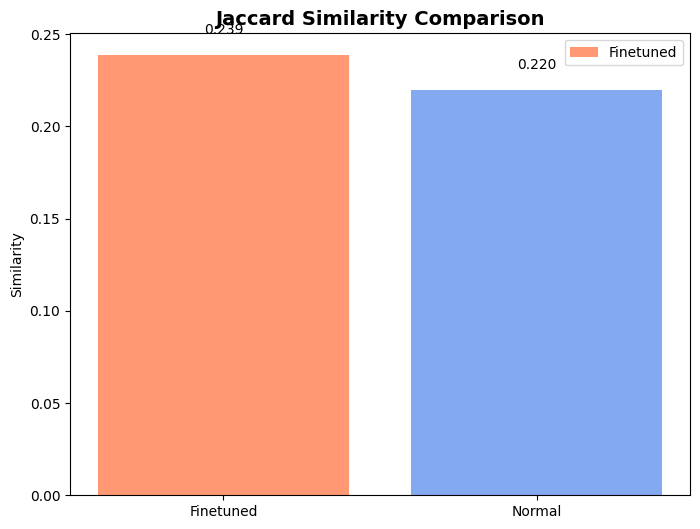

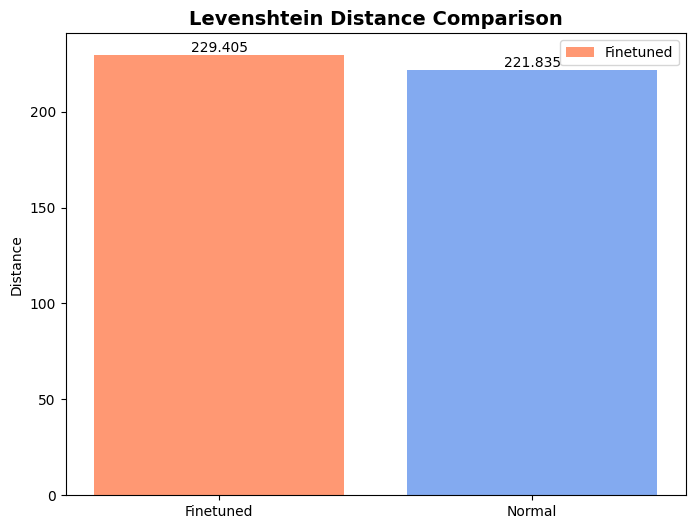

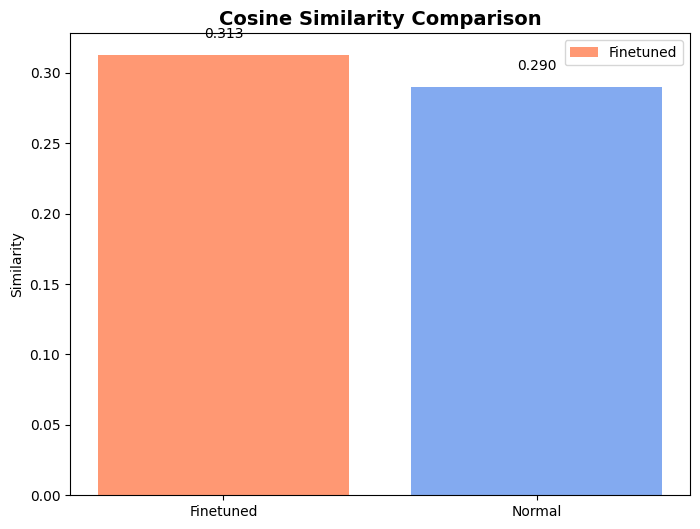

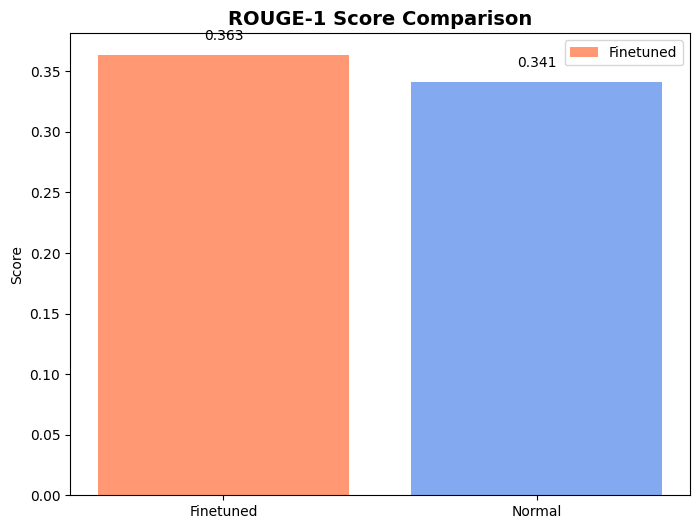

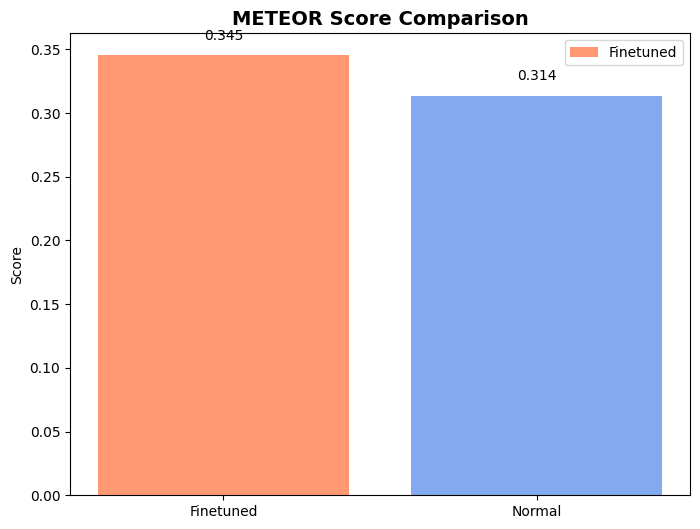

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
import evaluate

# Load dataset
path = r"C:\\Users\\sapan\\Desktop\\laptop4\\model_comparison_results\\detailed_results.csv"
df = pd.read_csv(path)

# Clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^a-z0-9 ]", "", text)
        return text.strip()
    return ""

# Load metrics
eval_rouge = evaluate.load("rouge")
eval_bleu = evaluate.load("bleu")
eval_meteor = evaluate.load("meteor")


# Similarity metrics
jaccard = []
levenshtein_dist = []
cosine_sims = []
rouge1_normal, rouge1_finetuned = [], []
bleu_normal, bleu_finetuned = [], []
meteor_normal, meteor_finetuned = [], []
bertscore_normal, bertscore_finetuned = [], []

# TF-IDF and CountVectorizer
vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer(binary=True)

for i, row in df.iterrows():
    ref = clean_text(row['reference_summary'])
    finetuned = clean_text(row['finetuned_summary'])
    normal = clean_text(row['normal_summary'])

    # Jaccard similarity using CountVectorizer
    bow = count_vectorizer.fit_transform([ref, finetuned, normal])
    jaccard_ft = jaccard_score(bow[0].toarray()[0], bow[1].toarray()[0])
    jaccard_norm = jaccard_score(bow[0].toarray()[0], bow[2].toarray()[0])

    # Levenshtein distance
    lev_ft = Levenshtein.distance(ref, finetuned)
    lev_norm = Levenshtein.distance(ref, normal)

    # Cosine similarity
    tfidf = vectorizer.fit_transform([ref, finetuned, normal])
    cos_ft = cosine_similarity(tfidf[0], tfidf[1])[0][0]
    cos_norm = cosine_similarity(tfidf[0], tfidf[2])[0][0]

    # ROUGE-1
    rouge_ft = eval_rouge.compute(predictions=[finetuned], references=[ref])["rouge1"]
    rouge_norm = eval_rouge.compute(predictions=[normal], references=[ref])["rouge1"]


    # METEOR
    meteor_ft = eval_meteor.compute(predictions=[finetuned], references=[ref])["meteor"]
    meteor_norm = eval_meteor.compute(predictions=[normal], references=[ref])["meteor"]


    jaccard.append([jaccard_ft, jaccard_norm])
    levenshtein_dist.append([lev_ft, lev_norm])
    cosine_sims.append([cos_ft, cos_norm])
    rouge1_finetuned.append(rouge_ft)
    rouge1_normal.append(rouge_norm)

    meteor_finetuned.append(meteor_ft)
    meteor_normal.append(meteor_norm)


# Convert to DataFrame
metrics_df = pd.DataFrame({
    "Jaccard_FT": [x[0] for x in jaccard],
    "Jaccard_Normal": [x[1] for x in jaccard],
    "Levenshtein_FT": [x[0] for x in levenshtein_dist],
    "Levenshtein_Normal": [x[1] for x in levenshtein_dist],
    "Cosine_FT": [x[0] for x in cosine_sims],
    "Cosine_Normal": [x[1] for x in cosine_sims],
    "ROUGE1_FT": rouge1_finetuned,
    "ROUGE1_Normal": rouge1_normal,

    "METEOR_FT": meteor_finetuned,
    "METEOR_Normal": meteor_normal,

})

# Plotting function
def plot_metric(metric_ft, metric_norm, title, ylabel):
    plt.figure(figsize=(8,6))
    x = np.arange(2)
    values = [np.mean(metric_ft), np.mean(metric_norm)]
    bars = plt.bar(x, values, color=["#FF7F50", "#6495ED"], alpha=0.8)
    plt.xticks(x, ["Finetuned", "Normal"])
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, weight="bold")
    plt.legend(["Finetuned", "Normal"], loc="upper right")

    # Annotate values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

    plt.show()

# Plot metrics
plot_metric(metrics_df["Jaccard_FT"], metrics_df["Jaccard_Normal"], "Jaccard Similarity Comparison", "Similarity")
plot_metric(metrics_df["Levenshtein_FT"], metrics_df["Levenshtein_Normal"], "Levenshtein Distance Comparison", "Distance")
plot_metric(metrics_df["Cosine_FT"], metrics_df["Cosine_Normal"], "Cosine Similarity Comparison", "Similarity")
plot_metric(metrics_df["ROUGE1_FT"], metrics_df["ROUGE1_Normal"], "ROUGE-1 Score Comparison", "Score")
plot_metric(metrics_df["METEOR_FT"], metrics_df["METEOR_Normal"], "METEOR Score Comparison", "Score")
